In [1]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# USTAWIENIA I TRANSFORMACJE ======================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ŁADOWANIE DANYCH =================================================================
root_dir = 'root/celeba'

# Ładowanie zestawów danych
train_dataset = CustomCelebA(root=root_dir, split="train", attr_index=31, transform=transform)
valid_dataset = CustomCelebA(root=root_dir, split="valid", attr_index=31, transform=transform)
test_dataset = CustomCelebA(root=root_dir, split="test", attr_index=31, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Chosen: Smiling
Total images in split 'train': 162770
Positive samples: 78080, Negative samples: 84690
Balanced dataset size: 156160
Chosen: Smiling
Total images in split 'valid': 19867
Positive samples: 9602, Negative samples: 10265
Balanced dataset size: 19204
Chosen: Smiling
Total images in split 'test': 19962
Positive samples: 9987, Negative samples: 9975
Balanced dataset size: 19950


Train Dataset:


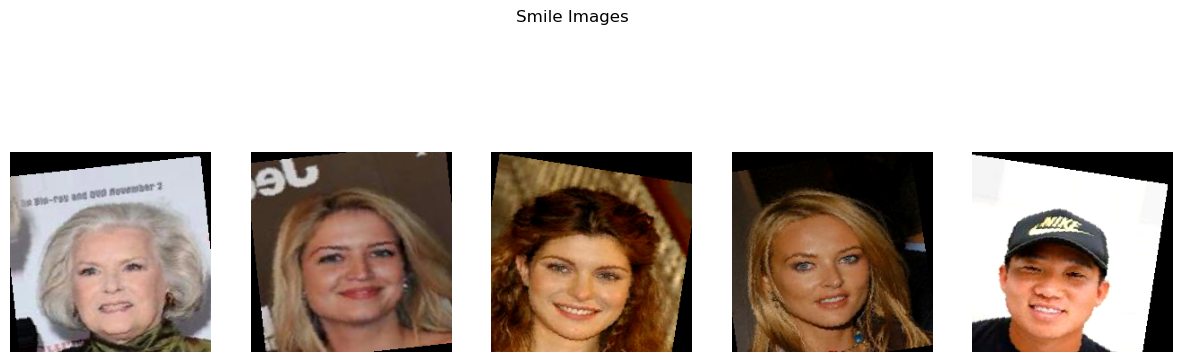

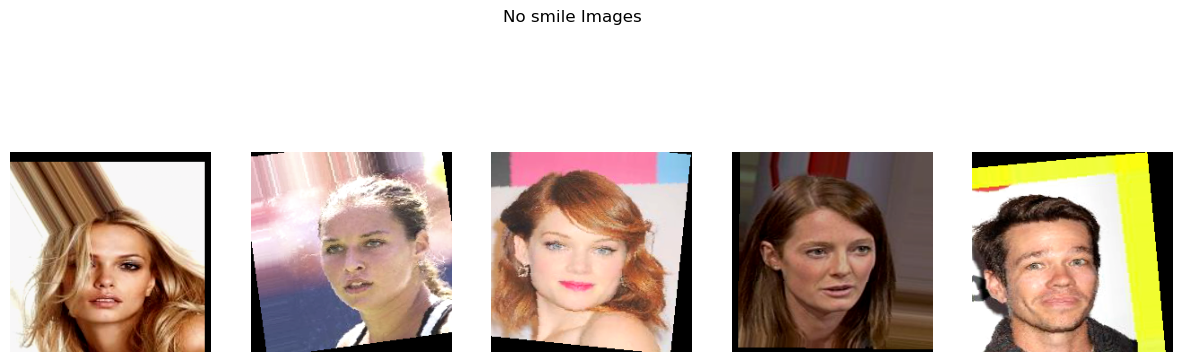

In [3]:
# WYPISYWANIE PRZYKŁADÓW ==========================================================
def show_samples_from_loader(loader, num_samples=5):
    smile_images = []
    sad_images = []
    for images, labels in loader:
        for img, label in zip(images, labels):
            if label == 1 and len(smile_images) < num_samples:
                smile_images.append(img)
            elif label == 0 and len(sad_images) < num_samples:
                sad_images.append(img)
            if len(smile_images) == num_samples and len(sad_images) == num_samples:
                break
        if len(smile_images) == num_samples and len(sad_images) == num_samples:
            break

    # Display smile images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle("Smile Images")
    for i, img in enumerate(smile_images):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        img = img.clamp(0, 1)  # Clamp values to be in valid range
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

    # Display no smile images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle("No smile Images")
    for i, img in enumerate(sad_images):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        img = img.clamp(0, 1)  # Clamp values to be in valid range
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

print("Train Dataset:")
show_samples_from_loader(train_loader)

In [4]:
# MODEL MOBILENET Z KLASYFIKATOREM =================================================
class SmileClassifier(nn.Module):
    def __init__(self, base_model):
        super(SmileClassifier, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Sequential(
            nn.Linear(1000, 128),  # Wyjście MobileNet (1000-dim)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # Wyjście binarne
            nn.Sigmoid()
        )

    def forward(self, x):
        with torch.no_grad():
            features = self.base_model(x)  # Zamrażamy MobileNet
        return self.classifier(features)

base_model = models.mobilenet_v2(pretrained=True).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
base_model.eval()

/Users/mateusz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mateusz/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = SmileClassifier(base_model).to(device)

# FUNKCJE STRATY I OPTIMIZATOR ====================================================
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


Using device: mps


/Users/mateusz/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
# TRENING I WALIDACJA =============================================================
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predictions = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

In [7]:
#EARLY STOPPING
early_stopping = EarlyStopping(patience=5, delta=0.01, path="smile_final.pth")

# GŁÓWNY PROCES TRENINGU ======================================================
best_val_loss = float('inf')

num_epochs = 25
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Adjust learning rate
    scheduler.step(val_loss)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

100%|██████████| 2440/2440 [10:27<00:00,  3.89it/s]


Epoch 1/25, Train Loss: 0.5007, Val Loss: 0.4663, Val Accuracy: 79.00%


100%|██████████| 2440/2440 [11:34<00:00,  3.52it/s]


Epoch 2/25, Train Loss: 0.4825, Val Loss: 0.4434, Val Accuracy: 79.44%


100%|██████████| 2440/2440 [11:40<00:00,  3.48it/s]


Epoch 3/25, Train Loss: 0.4760, Val Loss: 0.4487, Val Accuracy: 79.20%


100%|██████████| 2440/2440 [11:10<00:00,  3.64it/s]


Epoch 4/25, Train Loss: 0.4752, Val Loss: 0.4378, Val Accuracy: 79.71%


100%|██████████| 2440/2440 [10:57<00:00,  3.71it/s]


Epoch 5/25, Train Loss: 0.4708, Val Loss: 0.4344, Val Accuracy: 80.07%


100%|██████████| 2440/2440 [10:10<00:00,  3.99it/s]


Epoch 6/25, Train Loss: 0.4702, Val Loss: 0.4358, Val Accuracy: 79.97%


100%|██████████| 2440/2440 [10:40<00:00,  3.81it/s]


Epoch 7/25, Train Loss: 0.4682, Val Loss: 0.4411, Val Accuracy: 79.91%
Early stopping triggered!


In [8]:
# TESTOWANIE MODEL ================================================================
model.load_state_dict(torch.load("smile_final.pth"))
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

/var/folders/q7/wxqvnl3j4zv3s1b841gddlvr0000gn/T/ipykernel_35929/2029433426.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("smile_final

Test Loss: 0.4490, Test Accuracy: 78.77%


In [13]:
#WIDERFACE

import pandas as pd
from pathlib import Path
from PIL import Image
from torchvision import models

def test_custom_images_with_csv(model, image_dir, csv_file, transform, device):
    model.eval()
    correct = 0
    total = 0

    # Load CSV with image names and labels
    labels_df = pd.read_csv(csv_file)

    with torch.no_grad():
        for _, row in labels_df.iterrows():
            img_name = row['image']
            label = 1 if row['label'] == 'smiling' else 0

            img_path = Path(image_dir) / img_name

            if not img_path.exists():
                print(f"Image not found: {img_path}")
                continue

            # Load and preprocess image
            image = Image.open(img_path).convert("RGB")
            image = transform(image).unsqueeze(0).to(device)
            label = torch.tensor([label]).to(device)

            # Model prediction
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)

            # Compare prediction with the true label
            total += 1
            correct += (predicted == label).sum().item()

    accuracy = 100 * correct / total
    print(f"Custom Dataset Accuracy: {accuracy:.2f}%")
    return accuracy

# ŚCIEŻKA DO DANYCH TESTOWYCH
custom_image_dir = "WIDER_FACE/extracted"
csv_file_path = "WIDER_FACE/extracted/labels.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.load_state_dict(torch.load("smile_final.pth"))

# TESTOWANIE NA WŁASNYCH ZDJĘCIACH Z CSV
test_custom_images_with_csv(model, custom_image_dir, csv_file_path, transform, device)


/var/folders/q7/wxqvnl3j4zv3s1b841gddlvr0000gn/T/ipykernel_35929/2563385800.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("smile_fina

Custom Dataset Accuracy: 74.20%


74.2

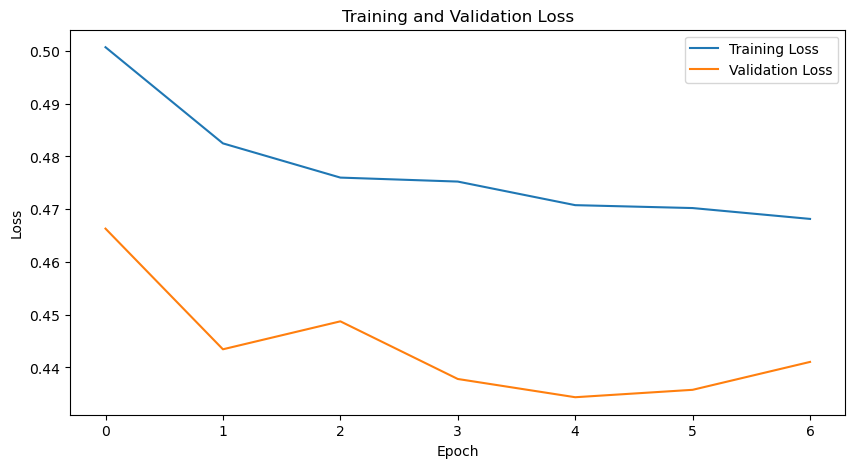

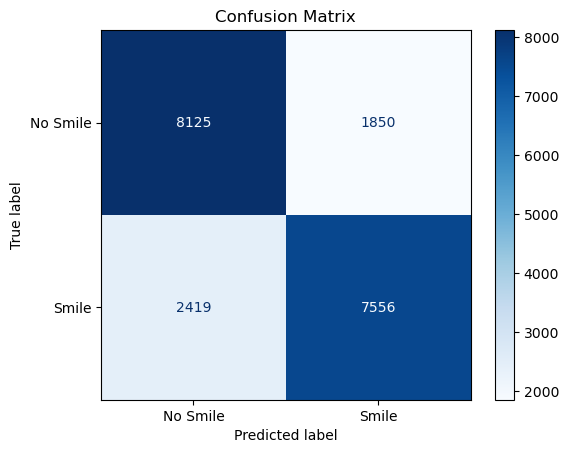

In [10]:
# WYKRESY ========================================================================
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

# Confusion Matrix
model.eval()
def plot_confusion_matrix(loader, device):
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            predictions = (outputs > 0.5).float().cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Smile", "Smile"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

plot_loss(train_losses, val_losses)
plot_confusion_matrix(test_loader, device)
